# Downloading and importing requiered libraries

In [1]:
from IPython.display import clear_output

!git clone https://github.com/sodeeplearning/simpletorch
!pip install ultralytics
!pip install supervision

clear_output(True)
print("All requiered modules have been downloaded")

All requiered modules have been downloaded


In [2]:
from ultralytics import YOLO
import simpletorch as ST
import io
import zipfile
import requests
import json
import os
import torch
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import supervision as sv

print("All requiered libraries have been imported")

All requiered libraries have been imported


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# Downloading dataset

In [7]:
print("Downloading has been started")

url = "https://storage.yandexcloud.net/net-nomer-dataset/Net-Nomer-a-data_processing.zip"

response = requests.get(url)
zip = zipfile.ZipFile(io.BytesIO(response.content))
zip.extractall()
del zip

print("The dataset has been downloaded")
print("Starting detection dataset processing")

def image_num(path):
  last_slash = path.rfind('/')
  dot = path.rfind('.')
  return int(path[last_slash + 1:dot])

def string_perf(string):
    return int(string[string.find('>') + 1: string.rfind('<')])

def xml_perf(path):
    with open(path, 'r') as f:
        file = f.read()
        massive = file.split('\n')
        return (string_perf(massive[-7]) / 2592,
                string_perf(massive[-6]) / 1552,
                string_perf(massive[-5]) / 2592,
                string_perf(massive[-4]) / 1552)

def bboxes_dataset(path_to_folder):
  files = sorted(ST.getting_files(path_to_folder), key=image_num)
  answer_tensor = torch.zeros((len(files), 4))
  for ind, current_path in enumerate(files):
    answer_tensor[ind] = torch.tensor(xml_perf(current_path))
  print(files)
  return answer_tensor

train_bboxes_dataset = bboxes_dataset("Dataset/boxes")

print("The dataset has been performed")

The dataset has been downloaded
Starting detection dataset processing
['Dataset/boxes/0.xml', 'Dataset/boxes/1.xml', 'Dataset/boxes/2.xml', 'Dataset/boxes/3.xml', 'Dataset/boxes/4.xml', 'Dataset/boxes/5.xml', 'Dataset/boxes/6.xml', 'Dataset/boxes/7.xml', 'Dataset/boxes/8.xml', 'Dataset/boxes/9.xml', 'Dataset/boxes/10.xml', 'Dataset/boxes/11.xml', 'Dataset/boxes/12.xml', 'Dataset/boxes/13.xml', 'Dataset/boxes/14.xml', 'Dataset/boxes/15.xml', 'Dataset/boxes/16.xml', 'Dataset/boxes/17.xml', 'Dataset/boxes/18.xml', 'Dataset/boxes/19.xml', 'Dataset/boxes/20.xml', 'Dataset/boxes/21.xml', 'Dataset/boxes/22.xml', 'Dataset/boxes/23.xml', 'Dataset/boxes/24.xml', 'Dataset/boxes/25.xml', 'Dataset/boxes/26.xml', 'Dataset/boxes/27.xml', 'Dataset/boxes/28.xml', 'Dataset/boxes/29.xml', 'Dataset/boxes/30.xml', 'Dataset/boxes/31.xml', 'Dataset/boxes/32.xml', 'Dataset/boxes/33.xml', 'Dataset/boxes/34.xml', 'Dataset/boxes/35.xml', 'Dataset/boxes/36.xml', 'Dataset/boxes/37.xml', 'Dataset/boxes/38.xml', 'Da

# Getting model and prediction analizing

In [4]:
detection_model = YOLO('yolov9c.pt')

In [5]:
output = detection_model("Dataset/photo/0.jpg")
output


image 1/1 /content/Dataset/photo/0.jpg: 384x640 8 persons, 4 cars, 2 trucks, 2 backpacks, 123.7ms
Speed: 3.3ms preprocess, 123.7ms inference, 567.6ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [6]:
train_bboxes_dataset

NameError: name 'train_bboxes_dataset' is not defined

#Adaptating dataset

## Getting dataset (Skip if loaded)

In [122]:
def cropping_image(image, x_min, y_min, x_max, y_max, x_shape, y_shape):
  top = int(y_min * y_shape)
  left = int(x_min * x_shape)
  height = int((y_max - y_min) * y_shape)
  width = int((x_max - x_min) * x_shape)
  return transforms.functional.crop(img = image,
                                    top = top,
                                    left = left,
                                    height = height,
                                    width = width)

def detection_pred_processing(image_id):
  image_path = f"Dataset/photo/{image_id}.jpg"
  detection_output = detection_model(image_path)[0]
  answer_tensor = torch.zeros((0, 4))
  number_plate_coord = train_bboxes_dataset[image_id]
  nx_min, ny_min, nx_max, ny_max = number_plate_coord
  classes_with_number = [2, 3, 5, 7]
  transform = transforms.Resize((512, 512))
  answer_images = torch.zeros((0, 3, 512, 512))
  image_tensor = ST.jpg_tensor(image_path)
  y_shape, x_shape = image_tensor.shape[-2:]

  for current_class, (x_min, y_min, x_max, y_max) in zip(detection_output.boxes.cls, detection_output.boxes.xyxyn):
    if current_class.item() in classes_with_number:
      if x_min < nx_min and y_min < ny_min and x_max > nx_max and y_max > ny_max:
        coordinates = torch.tensor([(nx_min - x_min) / (x_max - x_min),
                                    (ny_min - y_min) / (y_max - y_min),
                                    (nx_max - x_min) / (x_max - x_min),
                                    (ny_max - y_min) / (y_max - y_min)]).unsqueeze(0)
        answer_tensor = torch.cat((answer_tensor,
                                   coordinates),dim=0)
        adding_image = transform(cropping_image(image = image_tensor,
                                      x_min = x_min,
                                      y_min = y_min,
                                      x_max = x_max,
                                      y_max = y_max,
                                      x_shape = x_shape,
                                      y_shape = y_shape)).unsqueeze(0)
        answer_images = torch.cat((answer_images,
                                   adding_image), dim=0)

  return answer_images, answer_tensor


image 1/1 /content/Dataset/photo/4.jpg: 384x640 1 person, 8 cars, 1534.9ms
Speed: 5.7ms preprocess, 1534.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


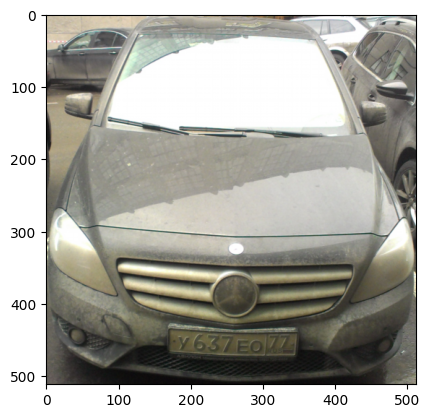

In [100]:
ST.imshow(detection_pred_processing(4)[0].squeeze(0))

In [123]:
def get_dataset():
  answer_images = torch.zeros((0, 3, 512, 512))
  answer_bboxes = torch.zeros((0, 4))

  for i in range(202):
    print(f"{i + 1} sample now")
    current_images, current_bboxes = detection_pred_processing(i)
    answer_images = torch.cat((answer_images,
                               current_images), dim=0)
    answer_bboxes = torch.cat((answer_bboxes,
                               current_bboxes), dim=0)

  return answer_images, answer_bboxes

In [124]:
images_dataset, bboxes_dataset = get_dataset()
clear_output(True)
print("The dataset has been performed")

The dataset has been performed


In [105]:
def multy_image(image, multy_factor): # Increasing dataset size in multy_factor times
    augmentation = ST.transforms.Compose([
        ST.transforms.ToPILImage(),
        ST.transforms.ColorJitter(
            brightness=0.4,
            contrast=0.3,
            saturation=0.3,
            hue=0.1,
        ),
        ST.transforms.ToTensor()
    ])

    answer = torch.zeros((multy_factor, 3, 512, 512))

    for current_augmentation in range(multy_factor):
        answer[current_augmentation] = augmentation(image)

    return answer

def augment_dataset(dataset, multy_factor, num_of_images = 202):
    images_tensor = dataset

    train_images = torch.zeros((0, 3, 512, 512))
    for ind, current_image in enumerate(images_tensor):
        train_images = torch.cat([train_images, multy_image(
            image = current_image,
            multy_factor = multy_factor
        )], dim = 0)
    return train_images

augmented_images_dataset = augment_dataset(dataset = images_dataset,
                                           multy_factor = 5,
                                           num_of_images = images_dataset.shape[0])

In [125]:
saving_dir = "drive/MyDrive/"
torch.save(augmented_images_dataset, saving_dir + "Detection_images.pt")
torch.save(bboxes_dataset, saving_dir + "Detection_bboxes.pt")

##loading dataset

In [4]:
path_to_data = "drive/MyDrive/"
augmented_images_dataset = torch.load(path_to_data + "Detection_images.pt")
bboxes_dataset = torch.load(path_to_data + "Detection_bboxes.pt")

In [5]:
augmented_images_dataset.shape

torch.Size([930, 3, 512, 512])

In [6]:
train_images = augmented_images_dataset[:800]
val_images = augmented_images_dataset[800:]
train_bboxes = bboxes_dataset[:160]
val_bboxes = bboxes_dataset[160:]

tensor([0.3464, 0.8613, 0.6735, 0.9212])

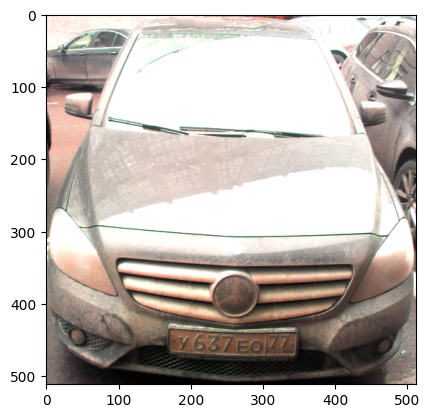

In [7]:
id = 24
ST.imshow(train_images[id])
train_bboxes[id // 5]

#Getting CNN model

In [8]:
class CNN_Model (torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.convolutions = torch.nn.Sequential(*[
        ST.Conv_Block(
            input_channels = 3,
            output_channels = 64,
        ),
        ST.Conv_Block(
            input_channels = 64,
            output_channels = 128,
        ),
        ST.Conv_Block(
            input_channels = 128,
            output_channels = 256,
        ),
        ST.Conv_Block(
            input_channels = 256,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        torch.nn.Flatten()
    ])

    self.fs = torch.nn.Sequential(*[
        torch.nn.Linear(32768, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4),
    ])

  def forward(self, input_tensor):
    feature_map = self.convolutions(input_tensor)
    fs_bboxes = self.fs(feature_map)
    return fs_bboxes

cnn_model = CNN_Model().to(device)
print(f"{sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)} params in model")
cnn_model

9551864 params in model


CNN_Model(
  (convolutions): Sequential(
    (0): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Conv_Block(
      (Block): Sequential(
        (Dropo

In [9]:
cnn_model(torch.zeros(1, 3, 512, 512).to(device))

tensor([[-0.0197, -0.0096,  0.0958,  0.0264]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Training CNN model

In [10]:
num_of_epochs = 500
train_batch_size = 20
learning_rate = 1e-4
scheduler_gamma = 0.5
scheduler_freq = 300

show_every = 10
val_every = 10
val_batch_size = 20
best_val = 0.02

cnn_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = scheduler_gamma)

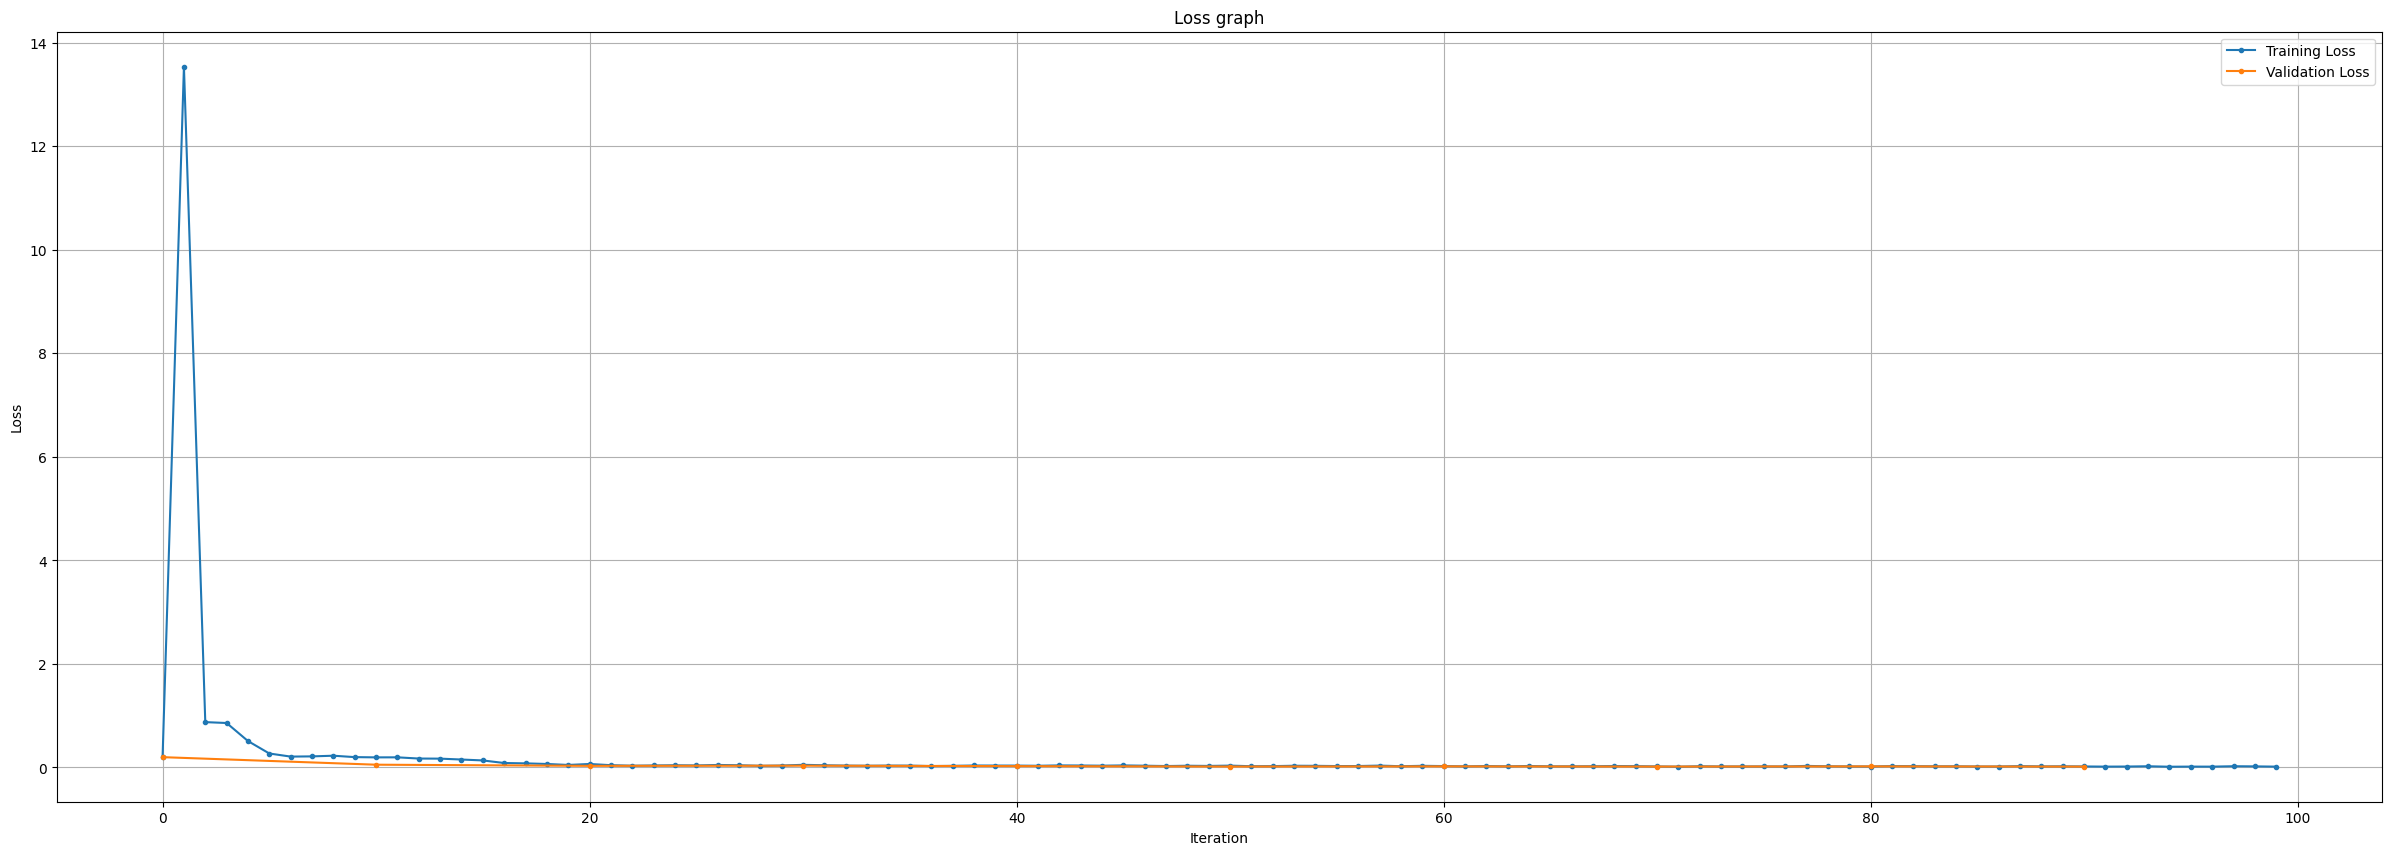

In [11]:
losses = {"train" : [], "val" : []}
cnn_model.train()

for epoch in range(1, num_of_epochs + 1):
  optimizer.zero_grad()
  train_batch = torch.randint(high = train_images.shape[0], size = [train_batch_size])

  train_pred = cnn_model(train_images[train_batch].to(device))
  train_loss = cnn_loss(train_pred, train_bboxes[train_batch // 5].to(device))

  train_loss.backward()
  optimizer.step()

  losses["train"].append(train_loss.item())

  if epoch % val_every == 0:
    with torch.no_grad():
      val_batch = torch.randint(high = val_images.shape[0], size = [val_batch_size])
      val_pred = cnn_model(val_images[val_batch].to(device))
      val_loss = cnn_loss(val_pred, val_bboxes[val_batch // 5].to(device))
      losses["val"].append(val_loss.item())
      print(val_loss.item())
      if (val_loss.item() < best_val):
        torch.save(cnn_model.state_dict(), "best_weights.pt")
        best_val = val_loss.item()
        print("The weights have been updated")

  if epoch % scheduler_freq == 0:
    scheduler.step()

  if epoch % show_every == 0:
      clear_output(True)
      fig, ax = plt.subplots(figsize=(30, 10))
      plt.title("Loss graph")
      plt.plot(losses["train"], ".-", label="Training Loss")
      plt.plot(torch.arange(0, epoch, show_every), losses["val"], ".-", label="Validation Loss")
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend()
      plt.grid()
      plt.show()


# CNN testing

In [12]:
def cnn_pred(image):
  cnn_model.load_state_dict(torch.load("best_weights.pt"))
  cnn_model.train()
  annotator = sv.BoxAnnotator()
  transform = transforms.Resize((512, 512))
  to_pil = transforms.ToPILImage()

  image_tensor = transform(image.unsqueeze(0)).to(device)
  coordinates = (cnn_model(image_tensor) * 512).tolist()
  ST.imshow(image)
  return coordinates

[[113.06800842285156,
  353.1136169433594,
  398.9593200683594,
  459.02911376953125]]

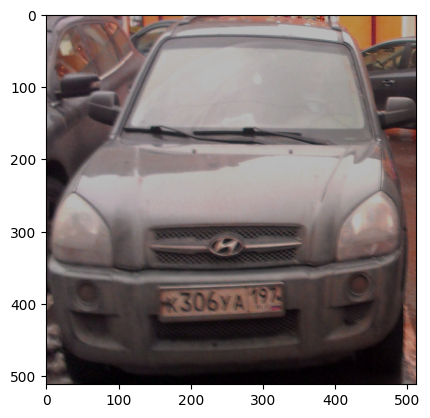

In [14]:
cnn_pred(val_images[1])